In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
import h5py
from tqdm import tqdm

In [2]:
# initialize constants
c = 0.299792458 #speed of light um/fs
# set pure spectral properties
lambda_0 = 0.8  # central wavelength
tau_0 = 15  # FL pulse duration 1/e2 intensity half-width (same def as beam waist)
# quick frequency properties
omega_0 = 2*np.pi*c/lambda_0
delta_omega = 2/tau_0
#set initial beam waist
w_0 = 4
#calculate Rayleigh range and beam waist
z_R = (omega_0*w_0**2)/(2*c)
# perturbation parameter
eps = w_0/z_R

In [3]:
tau_t = 30.0  # x group delay fs

In [4]:
t_start = -10*tau_0
t_end = 10*tau_0
n = 20
num_t = np.int_(np.round(n*(t_end-t_start)/(lambda_0/c)))
omega = np.linspace(1,n*omega_0,num_t)
omega_step = omega[1]-omega[0]
time = np.fft.fftshift(np.fft.fftfreq(num_t,omega_step/(2*np.pi)))
dt = time[1]-time[0]

z = np.array([0, 5*z_R])
x = np.linspace(-4*w_0, 4*w_0, 201)
y = np.linspace(-4*w_0, 4*w_0, 201)

temp = xr.DataArray(np.zeros([len(x), len(y), len(z), len(omega)]),
                   coords=[x, y, z, omega],
                   dims=['x', 'y', 'z', 'omega'])

pulse_temp = np.exp(-((temp.coords['omega']-omega_0)/delta_omega)**2)
x_omega = w_0*tau_t*(temp.coords['omega']-omega_0)/2
fft_norm_coeff = np.sqrt(len(omega))*omega_step/(delta_omega*np.sqrt(np.pi))

pulse_prep = pulse_temp*np.exp(1j*temp.coords['omega']*temp.coords['z']/c)
phi_G = np.arctan(temp.coords['z']/z_R)
w = w_0*np.sqrt(1+(temp.coords['z']/z_R)**2)
R = (temp.coords['z']) + (z_R**2)/(temp.coords['z'])
phi_norm = -(temp.coords['omega']/c)*(temp.coords['z']+((temp.coords['x']-x_omega)**2)/(2*R))
trans = np.exp(-((temp.coords['x']-x_omega)**2 + temp.coords['y']**2)/w**2)

c_2 = (w_0/w)**2 * np.exp(1j*(phi_norm + 2*phi_G))
c_3 = (w_0/w)**3 * np.exp(1j*(phi_norm + 3*phi_G))

rho = np.sqrt((temp.coords['x']-x_omega)**2 + temp.coords['y']**2)/w_0


E_z_spec = trans*pulse_prep*((c_2 - c_3*rho**2)*eps**2)
E_z_spec = E_z_spec.transpose('x', 'y', 'z', 'omega')
E_z_time = np.fft.fftshift(np.fft.ifft(E_z_spec, norm='ortho', axis=3), axes=3)*fft_norm_coeff
E_z_time = xr.DataArray(E_z_time,
                        coords=[x, y, z, time],
                        dims=['x', 'y', 'z', 'time'])

E_x_spec = trans*pulse_prep*((c_2*rho)*eps)*np.exp(+1j*np.pi/2)*(temp.coords['x']-x_omega)/np.sqrt((temp.coords['x']-x_omega)**2+((temp.coords['y']))**2)
E_x_spec.fillna(0.0)
E_x_spec = E_x_spec.transpose('x', 'y', 'z', 'omega')
E_x_time = np.fft.fftshift(np.fft.ifft(E_x_spec, norm='ortho', axis=3), axes=3)*fft_norm_coeff
E_x_time = xr.DataArray(E_x_time,
                        coords=[x, y, z, time],
                        dims=['x', 'y', 'z', 'time'])

E_y_spec = trans*pulse_prep*((c_2*rho)*eps)*np.exp(+1j*np.pi/2)*(temp.coords['y'])/np.sqrt((temp.coords['y'])**2+((temp.coords['x']-x_omega))**2)
E_y_spec.fillna(0.0)
E_y_spec = E_y_spec.transpose('x', 'y', 'z', 'omega')
E_y_time = np.fft.fftshift(np.fft.ifft(E_y_spec, norm='ortho', axis=3), axes=3)*fft_norm_coeff
E_y_time = xr.DataArray(E_y_time,
                        coords=[x, y, z, time],
                        dims=['x', 'y', 'z', 'time'])

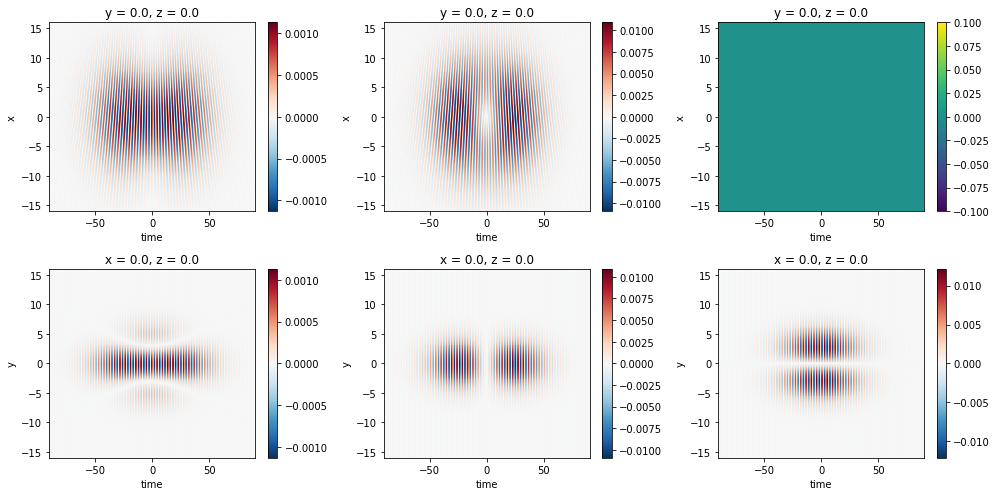

In [5]:
fig = plt.figure(figsize=[14, 7])

ax1 = plt.subplot(2, 3, 1)
np.real(E_z_time).sel(z=0, method='nearest').sel(y=0, method='nearest').plot()
plt.xlim(-2*(tau_0+tau_t), 2*(tau_0+tau_t))
plt.ylim(-4*w_0, 4*w_0)

ax2 = plt.subplot(2, 3, 4)
np.real(E_z_time).sel(z=0, method='nearest').sel(x=0, method='nearest').plot()
plt.xlim(-2*(tau_0+tau_t), 2*(tau_0+tau_t))
plt.ylim(-4*w_0, 4*w_0)

ax3 = plt.subplot(2, 3, 2)
np.real(E_x_time).sel(z=0, method='nearest').sel(y=0, method='nearest').plot()
plt.xlim(-2*(tau_0+tau_t), 2*(tau_0+tau_t))
plt.ylim(-4*w_0, 4*w_0)

ax4 = plt.subplot(2, 3, 5)
np.real(E_x_time).sel(z=0, method='nearest').sel(x=0, method='nearest').plot()
plt.xlim(-2*(tau_0+tau_t), 2*(tau_0+tau_t))
plt.ylim(-4*w_0, 4*w_0)

ax5 = plt.subplot(2, 3, 3)
np.real(E_y_time).sel(z=0, method='nearest').sel(y=0, method='nearest').plot()
plt.xlim(-2*(tau_0+tau_t), 2*(tau_0+tau_t))
plt.ylim(-4*w_0, 4*w_0)

ax6 = plt.subplot(2, 3, 6)
np.real(E_y_time).sel(z=0, method='nearest').sel(x=0, method='nearest').plot()
plt.xlim(-2*(tau_0+tau_t), 2*(tau_0+tau_t))
plt.ylim(-4*w_0, 4*w_0)

plt.tight_layout()

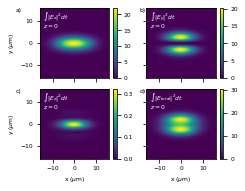

In [6]:
# Define figure dimensions
fig_width = 8.6/2.54  # width in inches
fig_height = 6.7/2.54       # height in inches
fig_size = [fig_width, fig_height]
# tell matplotlib to use latex font rendering
plt.rc('text', usetex=False)
# adjust fontsize
plt.rcParams.update({'font.size' : 6,
          'axes.labelsize' : 6,
          'legend.fontsize': 6,
          'xtick.labelsize' : 6,
          'ytick.labelsize' : 6,
          'lines.linewidth'   : 0.75,
          'lines.markersize'   : 2})
# adjust resolution
plt.rcParams['savefig.dpi'] = 600

fig = plt.figure(figsize = fig_size)

max_z = 0.00226724
max_I_z = 1.64255716e-05

ax1 = plt.subplot(2, 2, 1)
((np.abs(E_x_time)**2).sel(z=0, method='nearest').sum(dim='time')/max_z).transpose().plot(add_colorbar=True)
plt.xlim(-4*w_0, 4*w_0)
plt.ylim(-4*w_0, 4*w_0)

ax2 = plt.subplot(2, 2, 2)
((np.abs(E_y_time)**2).sel(z=0, method='nearest').sum(dim='time')/max_z).transpose().plot(add_colorbar=True)
plt.xlim(-4*w_0, 4*w_0)
plt.ylim(-4*w_0, 4*w_0)

ax3 = plt.subplot(2, 2, 3)
((np.abs(E_z_time)**2).sel(z=0, method='nearest').sum(dim='time')/max_z).transpose().plot(add_colorbar=True)
plt.xlim(-4*w_0, 4*w_0)
plt.ylim(-4*w_0, 4*w_0)

ax4 = plt.subplot(2, 2, 4)
((np.abs(E_z_time)**2+np.abs(E_y_time)**2+np.abs(E_x_time)**2).sel(z=0, method='nearest').sum(dim='time')/max_z).transpose().plot(add_colorbar=True)
plt.xlim(-4*w_0, 4*w_0)
plt.ylim(-4*w_0, 4*w_0)

ax1.set_title('')
ax2.set_title('')
ax3.set_title('')
ax4.set_title('')

ax1.text(0.05, 0.85, r'$\int{|E_x|^2}dt$', transform=ax1.transAxes, color='w')
ax2.text(0.05, 0.85, r'$\int{|E_y|^2}dt$', transform=ax2.transAxes, color='w')
ax3.text(0.05, 0.85, r'$\int{|E_z|^2}dt$', transform=ax3.transAxes, color='w')
ax4.text(0.05, 0.85, r'$\int{|E_{total}|^2}dt$', transform=ax4.transAxes, color='w')
ax5.text(0.05, 0.85, r'$E_z$', transform=ax5.transAxes, color='k')
ax6.text(0.05, 0.85, r'$E_x$', transform=ax6.transAxes, color='k')

ax1.text(0.05, 0.72, r'$z=0$', transform=ax1.transAxes, color='w')
ax2.text(0.05, 0.72, r'$z=0$', transform=ax2.transAxes, color='w')
ax3.text(0.05, 0.72, r'$z=0$', transform=ax3.transAxes, color='w')
ax4.text(0.05, 0.72, r'$z=0$', transform=ax4.transAxes, color='w')

ax1.text(-0.35, 0.95, 'a)', transform=ax1.transAxes)
ax2.text(-0.1, 0.95, 'b)', transform=ax2.transAxes)
ax3.text(-0.35, 0.95, 'c)', transform=ax3.transAxes)
ax4.text(-0.1, 0.95, 'd)', transform=ax4.transAxes)
ax5.text(-0.35, 0.95, 'e)', transform=ax5.transAxes)
ax6.text(-0.1, 0.95, 'f)', transform=ax6.transAxes)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel(r'x ($\mu$m)')
ax4.set_xlabel(r'x ($\mu$m)')

ax1.set_ylabel(r'y ($\mu$m)')
ax2.set_ylabel('')
ax3.set_ylabel(r'y ($\mu$m)')
ax4.set_ylabel('')

ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.tight_layout()

#plt.savefig('report/figures/SC_standard.png')